# Lab One
### Authors: Eric Smith, Tyler Giallanza, Oscar Vallner

## What is DeepDream?

DeepDream is a technique used for image generation from pre-trained convolutional neural networks. Although the technique is most famous for producing outlandish-looking artistic pictures, there are practical use-cases as well.

## Why DeepDream?

DeepDream can be used practically to gain insight into how a convolutonal neural network makes classification decisions. By choosing a layer and modifying an input image to maximize the activation outputs of that layer's filters, the final image contains features that represent in some way what the layer activations are most sensitive to.
This is very useful for determining what function each layer serves in a trained network. For example, if an image generated by a layer contains a great deal of spirals or swirling shapes, it can be intuited that this layer is sensitive to curvature. For deeper layers, this technique becomes even more useful. Because deeper layers operate at higher levels of abstraction, DeepDream output from a deeper layer often contains these structured objects such as dogs or cats.

![img](https://d19fbfhz0hcvd2.cloudfront.net/UC/wp-content/uploads/2015/07/4ZSWD4L-e1436336191130.jpg)
Figure 1: DeepDream genererating animals as well as animal body parts (such as eyes).

In a network designed for a large-scale classification task, such as discriminating between the 1000 classes that comprise the ImageNet dataset, visualizing higher layers can help yield insight into what the model is most sensitive to predicting. For example, DeepDream visualizations of InceptionV3 often result in images of animals. This information is useful to someone choosing a model for a task that does not involve animals - the high sensitivity of InceptionV3 to animals as demonstrated by DeepDream may indicate that it is not the best model for this particular use-case.

## Chosing a Model for DeepDream

DeepDream modifies an image to maximally excite layers of a pre-trained model. The choice of model thus directly impacts the quality and structure of the output images. We chose to use VGGNet as our model for DeepDream visualization. We made this choice for a number of reasons.

![vgg](https://www.researchgate.net/profile/Kasthurirangan_Gopalakrishnan/publication/319952138/figure/fig2/AS:613973590282251@1523394119133/A-schematic-of-the-VGG-16-Deep-Convolutional-Neural-Network-DCNN-architecture-trained.png)
Figure 2: VGG-16 architecture.

First, VGG-16 has a very straightforward architecture - all convolutional layers proceed sequentially, unlike the split-transform-merge branched pathway strategy found in Inception-based architectures. This is an appealing feature for a model visualized with DeepDream because it becomes clearer what each layer is responsible for. If we were to use Inception, for example, it would be unclear which layers comprising each block are responsible for the block's visualizations.


![inception](https://cdn-images-1.medium.com/max/1600/1*acUVChT9lBW4vKaAKQhOOw.png)
Figure 3: An example of a block taken from an Inception-based architecture. DeepDream must operate on the "filter concatenation" layer, making it difficult to determine how each layer in the Inception block contributes to the final visualization.

Other models of comparable performance on ImageNet that have similar structures, most notably ResNet, are often much deeper, wherein the shallowest version of ResNet still contains 34 layers. Having more layers present in a network yields more options for which layers to include in a DeepDream model. This makes it difficult to search combinations of layers, as the number of such combinations is exponentially larger.

Second, our empirical testing of VGGNet and InceptionV3 revealed that VGGNet produced better looking images. We speculate that this is due to the layers of abstraction being more clearly defined between layers. Since each Inception block contains multiple convolutional layers in parallel, whereas VGG layers flow sequentially, the information distillation pipeline is more straightforward for VGGNet. Furthermore, we only tested a few hyperparameter combinations for each architecture rather than exhaustively search the hhyperparameter space. Thus, it is possible that for different parameters Inception would yield better results, but for the parameters we tested VGGNet seemed to be the most logical choice of model.

## DeepDream Implementation

In this section we will implement DeepDream using Keras. We will start off with an implementation of InceptionV3 that has been pretrained on the ImageNet dataset. This code is heavily based on Francois Chollet's implementation provided in the Deep Learning with Python book and implemented [here](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.2-deep-dream.ipynb).

In [ ]:
from keras.applications import inception_v3
from keras.applications import vgg16
from keras import backend as K

#We are using a pretrained model and thus should disable learning functions
K.set_learning_phase(0)

#Load the pre-trained VGG16 model based on the imagenet dataset
model = vgg16.VGG16(weights='imagenet', include_top=False)

In [ ]:
print([layer.name for layer in model.layers if layer.name.startswith('block')]) #The names of each layer in the model

Next, we use gradient ascent to iteratively update the input image. Unlike the example notebook from class that updated the input image to maximize the activation of a single filter, here we update the input image to maximize the activations of all filters in a given layer. Furthermore, we include multiple layers that are weighted differently.

Earlier model layers detect features at a lower level of abstraction, and deeper layers detect higher levels of abstraction. For example, the first few layers likely detect edges and textures, whereas later layers likely detect class-relevant information, such as the presence of ears in a dog. Because we want varied levels of abstraction in our output image, we include layers from earlier in the network as well as layers from later in the network.

The loss for our gradient ascent is comprised of a weighted sum for the losses of each layer we are examining. Each layer's loss is the L2 norm - the average sum of squares for each filter activation in the layer.

In [ ]:
#This defines the amount that each chosen layer contributes to the visualization
#Note that layer names are pre-determined by the already created VGG16 model
layer_contributions = {
    'block2_conv2': 0.2,
    'block3_conv3': 6.,
    'block4_conv3': 10.,
    'block5_conv3': 4.,
}

#Map each layer object to the name of the layer - this allows us to access the layers we defined in the
#layer contributions dictionary
layer_dict = dict([(layer.name, layer) for layer in model.layers])

#Define the loss function
loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    #The loss for each layer is the L2 norm
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling #Skip the boarders to make the edges look better

With the loss function defined, we can now code the gradient ascent algorithm. Notice that we normalize the gradients at each step with the L1 norm. This step is a "trick" that helps training because the gradients un-normalized can occupy a great range of values. Normalization ensures that the gradient occupies a similar range for every iteration. The choice of L1 for normalization as opposed to a different normalization scheme is somewhat arbitrary; this choice worked empirically in the original DeepDream code so we choose to adopt it here as well.

In [ ]:
#Layer containing the image we are iteratively updating
dream = model.input

#Gradients for the image w.r.t. the loss function
grads = K.gradients(loss, dream)[0]

#L1 gradient normalization trick - add epsilon value to prevent zero division
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)


#Return the loss and the gradients by inputing the generated image to the model
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

#Call the function that gets the model loss and gradients
def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

#Run the gradient ascent for a given number of iterations and a given step size (learning rate)
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss: #stop the iteration if the maximum loss has been reached
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

In [ ]:
import scipy
from keras.preprocessing import image

#Resizes a given image by zooming
def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

#Saves an image to disk
def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)

def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    
    # These constants are needed to put the VGG 
    # preprocessed inputs on a scale of 0-255
    # These constants were found here: https://asolda.github.io/post/deepdream/ 
    img[:,:,:,0] += 103.939
    img[:,:,:,1] += 116.779
    img[:,:,:,2] += 123.68
    
    # normalize the values to be from -1 to 1
    img /= 255.
    img -= 0.5
    img *= 2
    # Convert from BGR to RGB
    img = img[:,:, :, ::-1]
    return img

#Converts tensors into an image that can be visualized with matplotlib
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0)) #If the image channels are first flip the order so matplotlib can handle the image
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2. 
    x += 0.5
    x *= 255. #Move image into the 0-255 range
    x = np.clip(x, 0, 255).astype('uint8') #Clip any pixels that fall outside of the 0-255 range
    return x

To add a source of variation to the images, and to produce "dream" artifacts at different scales, we periodically increase the scale of the images. We run a set number of iterations for each scale, for a total of 5 scales. This results in artifacts produced at 5 different sizes, scaling the image up by 40% each time. This trick was also adopted from the original DeepDream paper due to its production of empirically better looking images.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


step = 0.01  # Gradient ascent step size
num_octave = 5  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 30  # Number of ascent steps per scale

# Don't constrain the loss
max_loss = None

# Path of the original image fed into DeepDream
base_image_path = 'bird.jpg'

# Format the image so it is interpretable by VGG
img = preprocess_image(base_image_path)

# Determine the different scales for image resizing
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# Reverse list of shapes, so that they are in increasing order
successive_shapes = successive_shapes[::-1]

# Resize the Numpy array of the image to our smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

#For every shape run gradient ascent for the given number of iterations
for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss) #Update the image iteratively with gradient ascent
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail #Trick to add back the missing information when resizing
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='bird_at_scale_' + str(shape) + '.png') #For each octave save a copy of the image to disk
    plt.show()

save_img(img, fname='final_dream.png') #Save the final image to disk

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()

We apply the deep dream process to the cat picture above and note the changes as octaves pass. Initially, it seems that the network is wanting to outline the object as it creates noise and emphasis in those areas. This gets clearer to see as we run more octaves. Not only does the cat attract the attention of the network we start to see that the face of the cat begins to become more and more exaggerated. On our final pass it becomes very exaggerated, to the point of adding more below the face of the cat. This hints that perhaps the network works on classification on edges and then to faces. Given that we are using an ImageNet trained network, this seems to be an understandable concusion

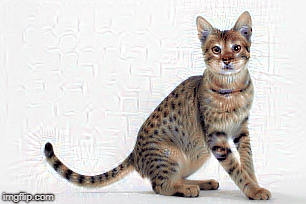

In [1]:
from IPython.display import Image
with open('cat.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

The noisy image has many more artifacts that pop up by going through the process. The salt & peper effect adds small noise to the background and the guassian blurs the features slightly. We see that the network takes these perturbations and continues to estimate featues out of them. The noisy picture seems to have multiple faces (near the tail, neck, legs) and eye like objects appear in the background. This could help as a better indicator of what the network tends towards. 